<a href="https://colab.research.google.com/github/andylynchul/ET5003_Assignments/blob/master/Week%205/2028189_ET5003_KaggleCompetition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_KaggleCompetition

In [1]:
#@title Current Date
Today = '2021-10-05' #@param {type:"date"}


# INTRODUCTION

Your introduction here.

***The goal is to use advanced Machine Learning methods to predict House price.***

## Imports

In [2]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
%matplotlib inline

In [4]:
# to plot
import matplotlib.colors
from mpl_toolkits.mplot3d import Axes3D

# to generate classification, regression and clustering datasets
import sklearn.datasets as dt

# to create data frames
from pandas import DataFrame

# to generate data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

In [5]:
# Scikit-learn is an open source machine learning library 
# that supports supervised and unsupervised learning
# https://scikit-learn.org/stable/
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
# Regular expression operations
#https://docs.python.org/3/library/re.html
import re 

# Natural Language Toolkit
# https://www.nltk.org/install.html
import nltk

# Stemming maps different forms of the same word to a common “stem” 
# https://pypi.org/project/snowballstemmer/
from nltk.stem import SnowballStemmer

# https://www.nltk.org/book/ch02.html
from nltk.corpus import stopwords

# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

In [7]:
!pip install gpy

     |████████████████████████████████| 959 kB 12.2 MB/s 
     |████████████████████████████████| 71 kB 8.5 MB/s 
  Created wheel for gpy: filename=GPy-1.10.0-cp37-cp37m-linux_x86_64.whl size=2565097 sha256=a1fc36aed952c869339332f3ef52948a6b79a0668b6331e4ef8966dc8ed56b52
  Stored in directory: /root/.cache/pip/wheels/f7/18/28/dd1ce0192a81b71a3b086fd952511d088b21e8359ea496860a
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102565 sha256=c927cb17da2281cf4a8234c76caac3f42b028447604c76bbe2411841aa1ef2e9
  Stored in directory: /root/.cache/pip/wheels/c8/95/f5/ce28482da28162e6028c4b3a32c41d147395825b3cd62bc810
Successfully built gpy paramz


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import GPy as GPy
import numpy as np
import pylab as pb
import pymc3 as pm
import arviz as az

In [10]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 11

# Define the color maps for plots
color_map = plt.cm.get_cmap('RdYlBu')
color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

# FUNCTIONS

In [11]:
# Global Varoable
drop_features = ['Index','ID','Services','Location','BER_class']
include_featues = ['Num_Bathrooms','Num_Beds','Price','Surface','Type']
nlp_features = ['Features','Description']

vectorizer = TfidfVectorizer(stop_words='english', max_features=10, max_df=0.5, smooth_idf=True, ngram_range=(2,5))

# Function to Detection Outlier on one-dimentional datasets.
def prepare_data(dframe, train):
    '''Function to Prepare Data for Model'''
    
    #define encoder
    enc = OneHotEncoder(handle_unknown='ignore')

    # drop low value features
    dframe = dframe.drop(drop_features, axis=1)

    if 'BER_class' in dframe:
      # Ordinally BER
      BERMap = {
        "A1": 1,
        "A2": 2,
        "A3": 3,
        "B1": 4,
        "B2": 5,
        "B3": 6,
        "C1": 7,
        "C2": 8,
        "C3": 9,
        "D1": 10,
        "D2": 11,
        "E1": 12,
        "E2": 13,
        "F": 14,
        "G": 15,
        "SINo666of2006exempt" : 0
      }
      dframe['BER_class'] = dframe['BER_class'].replace(BERMap)

      # impute the mean for BER
      dframe['BER_class'].fillna(round(dframe['BER_class'].mean(),0), inplace=True) # Only 2nd hand properties are missing BER. Therefore, we input the average for 2nd hand ones

    if 'Type' in dframe:
    # encode Type
      property_type_mapper = {
        "apartment": 1,
        "bungalow": 5,
        "detached": 9,
        "duplex": 2,
        "end-of-terrace": 6,
        "semi-detached": 8,
        "site": 3,
        "studio": 0,
        "terraced": 4,
        "townhouse": 7
      }
      dframe['Type'] = dframe['Type'].replace(property_type_mapper)

    #one hot encode Location in Dataset
    if 'Location' in dframe:
      dframe = pd.get_dummies(dframe, columns=['Location'],
                              dummy_na=True, 
                              drop_first=True)
    
    
    # Strip out the geo outliers
    if train==True:
      for i in range(0, len(include_featues)): 
        if (include_featues[i] != 'Price'):
          dframe = remove_outliers(dframe,include_featues[i])
    
      # Strip out the geo outliers
      index_train = dframe[(dframe['Longitude'] > -6.0)|(dframe['Latitude'] < 53.0)].index
      dframe.drop(index_train, inplace=True)

      dframe = dframe.reset_index(drop=True)

    return dframe

def nlp_data(dframe):
    '''Apply NLP Processing to a DataFrame'''

    for feature in dframe:
      # removing spaces
      if dframe[feature] is str:
        dframe[feature] = dframe[feature].str.replace("[^a-zA-Z#]", " ")
        
        # transforming to lowercase
        dframe[feature] = dframe[feature].apply(lambda x: x.lower())

        # Removing single letters
        dframe[feature] = dframe[feature].apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))
        
        # removing short words
        short_word = 4
        dframe[feature] = dframe[feature].apply(lambda x: ' '.join([w for w in x.split() if len(w)>short_word]))

        # Tokenisation
        tokenised_doc = dframe[feature].apply(lambda x: x.split())

        # remove stop-words
        tokenised_doc = tokenised_doc.apply(lambda x: [item for item in x if item not in stop_words])

        # normalise
        tokenised_doc = tokenised_doc.apply(lambda x: [normalize(word) for word in blurb_words])

        # de-tokenization
        detokenized_doc = []
        for i,token in enumerate(tokenised_doc):
          #print(i,token)
          t = ' '.join(token)
          detokenized_doc.append(t)

        # Replace feature with the de-tokenised text
        #print("Idx {} Len of detok {}".format(i, len(detokenized_doc)))
        dframe[feature] = detokenized_doc

    return dframe


v_features = []
def vectorise_data(dframe,feature):
    v_array = vectorizer.fit_transform(dframe[feature])
    v_features = [str(x).replace(" ","_") for x in vectorizer.get_feature_names()]
    v_data = pd.DataFrame(data=np.hstack([v_array.toarray()]), columns=v_features)
    # dframe = v_data.astype(bool).astype(int)
    dframe = v_data

    return dframe, v_features

# function to normalize words
def normalize(words):
  normalized_words = list()
  for word in words:
    # remove  the most common words
    if word.lower() not in stop: 
      # stemming
      new_word = stemmer.stem(word) 
      # lower case
      normalized_words.append(new_word.lower()) 
  return normalized_words
  
# Function to Detection Outlier on one-dimentional datasets.
def remove_outliers(dframe, feature):
    '''Function to Detect / Remove Outliers'''
  
    #define a list to accumlate anomalies
    anomalies = []
    
    # Set upper and lower limit to 3 standard deviation
    random_data_std = np.std(dframe[feature])
    random_data_mean = np.mean(dframe[feature])
    anomaly_cut_off = random_data_std * 3
    
    lower_limit  = random_data_mean - anomaly_cut_off 
    upper_limit = random_data_mean + anomaly_cut_off
    
    dframe = dframe.drop(dframe[(dframe[feature] < lower_limit) | (dframe[feature] > upper_limit)].index)

    return dframe

def plot_box_hist(dframe, features):
    '''Function to plot Box / Histogram pair for any feature'''
    no_feats = len(features)
  
    figH = plt.figure(figsize=(30,no_feats*5))

    for i in range(0, no_feats): 
        ax1 = figH.add_subplot(no_feats, 2, (i*2)+1)
        ax1.set_title("Boxplot of "+features[i])
        dframe.boxplot(column=[features[i]])

        ax2 = figH.add_subplot(no_feats, 2, (i*2)+2)
        ax2.set_title("Histogram of "+features[i])
        dframe[features[i]].hist(bins=20)

    plt.show()


# DATASET

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-CS6134/CS6134_SEM1_2021-2/tree/main/Week-5). 

2. Upload the dataset into your folder.



The challenge is to predict the final price of each house.

In [12]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Path, copy the path from your Drive
Path = '/content/drive/MyDrive/Masters/Year2/ET5003/Week5/Data/'

# House Data
train_data = Path + 'HousePrice_Train.csv'
test_data = Path + 'HousePrice_Test.csv'

# train data
df_train = pd.read_csv(train_data)

# test data
df_test = pd.read_csv(test_data)

# test data
#df_cost = pd.read_csv(cost_data)

# test data
#df_test = df_test.join(df_cost.drop("Id", axis=1))


print(df_train.shape)
print(df_test.shape)
#print(df_cost.shape)

Mounted at /content/drive
(1638, 14)
(702, 13)


In [13]:
df_train.tail()

,Index,ID,Location,Num_Bathrooms,Num_Beds,BER_class,Description,Services,Features,Latitude,Longitude,Type,Surface,Price
1633,1634,12424903,Blackrock,1,2,C2,Built in c.1930 38 Stradbrook Road is a deligh...,"Parking,Gas Fired Central Heating,Alarm,Wheelc...",Extremely convenient location \nWheelchair acc...,53.292767,-6.166668,bungalow,64.00,500000
1634,1635,12383142,Blackrock,3,5,C1,An impressive three-story family home superbly...,NaN,Gas fired central heating with underfloor heat...,53.284975,-6.178685,detached,175.96,795000
1635,1636,12426975,Lucan,2,3,A3,DNG Lucan's leading estate agents are delighte...,NaN,None,53.351667,-6.435278,semi-detached,98.00,340000
1636,1637,12198921,Sandymount,8,8,D2,Holyrood Castle is a most distinctive 19th cen...,NaN,None,53.328997,-6.221030,detached,507.00,2500000
1637,1638,12314237,Shankill,2,2,E1,A superb opportunity awaits to acquire this be...,NaN,Turn key condition\nWood burning stove\nSlider...,53.231438,-6.125022,semi-detached,50.00,370000


In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1638 entries, 0 to 1637
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Index          1638 non-null   int64  
 1   ID             1638 non-null   int64  
 2   Location       1638 non-null   object 
 3   Num_Bathrooms  1638 non-null   int64  
 4   Num_Beds       1638 non-null   int64  
 5   BER_class      1387 non-null   object 
 6   Description    1638 non-null   object 
 7   Services       577 non-null    object 
 8   Features       1638 non-null   object 
 9   Latitude       1638 non-null   float64
 10  Longitude      1638 non-null   float64
 11  Type           1638 non-null   object 
 12  Surface        1638 non-null   float64
 13  Price          1638 non-null   int64  
dtypes: float64(3), int64(5), object(6)
memory usage: 179.3+ KB


In [15]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Index,1638.0,8.195000e+02,472.994186,1.000000e+00,4.102500e+02,8.195000e+02,1.228750e+03,1.638000e+03
ID,1638.0,1.231930e+07,144754.041968,1.118567e+07,1.228104e+07,1.238055e+07,1.240548e+07,1.242836e+07
Num_Bathrooms,1638.0,2.054335e+00,1.241259,1.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
Num_Beds,1638.0,3.043346e+00,1.379650,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,2.700000e+01
Latitude,1638.0,5.335047e+01,0.076832,5.250186e+01,5.329426e+01,5.334139e+01,5.338203e+01,5.363059e+01
Longitude,1638.0,-6.255086e+00,0.144430,-6.497000e+00,-6.309613e+00,-6.247780e+00,-6.193982e+00,-1.744995e+00
Surface,1638.0,1.695407e+02,1791.793934,3.400000e+00,7.300000e+01,9.705000e+01,1.350000e+02,7.223639e+04
Price,1638.0,5.547196e+05,565203.162814,1.999500e+04,2.950000e+05,3.950000e+05,5.950000e+05,8.900000e+06


In [16]:
# Use this to get some high level information about the missing data
df_train.isna().sum()

Index               0
ID                  0
Location            0
Num_Bathrooms       0
Num_Beds            0
BER_class         251
Description         0
Services         1061
Features            0
Latitude            0
Longitude           0
Type                0
Surface             0
Price               0
dtype: int64

In [17]:
# Find the number of nulls/NaNs in the dataset as a percentage to see if any columns need to be considered for removal
print("Read of missing values as percentage of data set")
df_train.isna().sum()*100/len(df_train)

Read of missing values as percentage of data set


Index             0.000000
ID                0.000000
Location          0.000000
Num_Bathrooms     0.000000
Num_Beds          0.000000
BER_class        15.323565
Description       0.000000
Services         64.774115
Features          0.000000
Latitude          0.000000
Longitude         0.000000
Type              0.000000
Surface           0.000000
Price             0.000000
dtype: float64

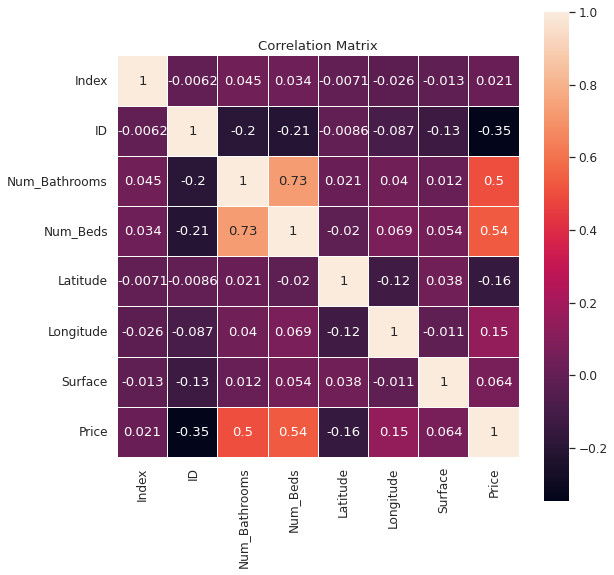

In [18]:
# calculate the correlation matrix
corr = df_train.corr()

# plot the heatmap
sns.set(font_scale=1.10)
plt.figure(figsize=(9, 9))
plt.title('Correlation Matrix')
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,linewidths=0.01,square=True,annot=True)

Pairplots of numerical features


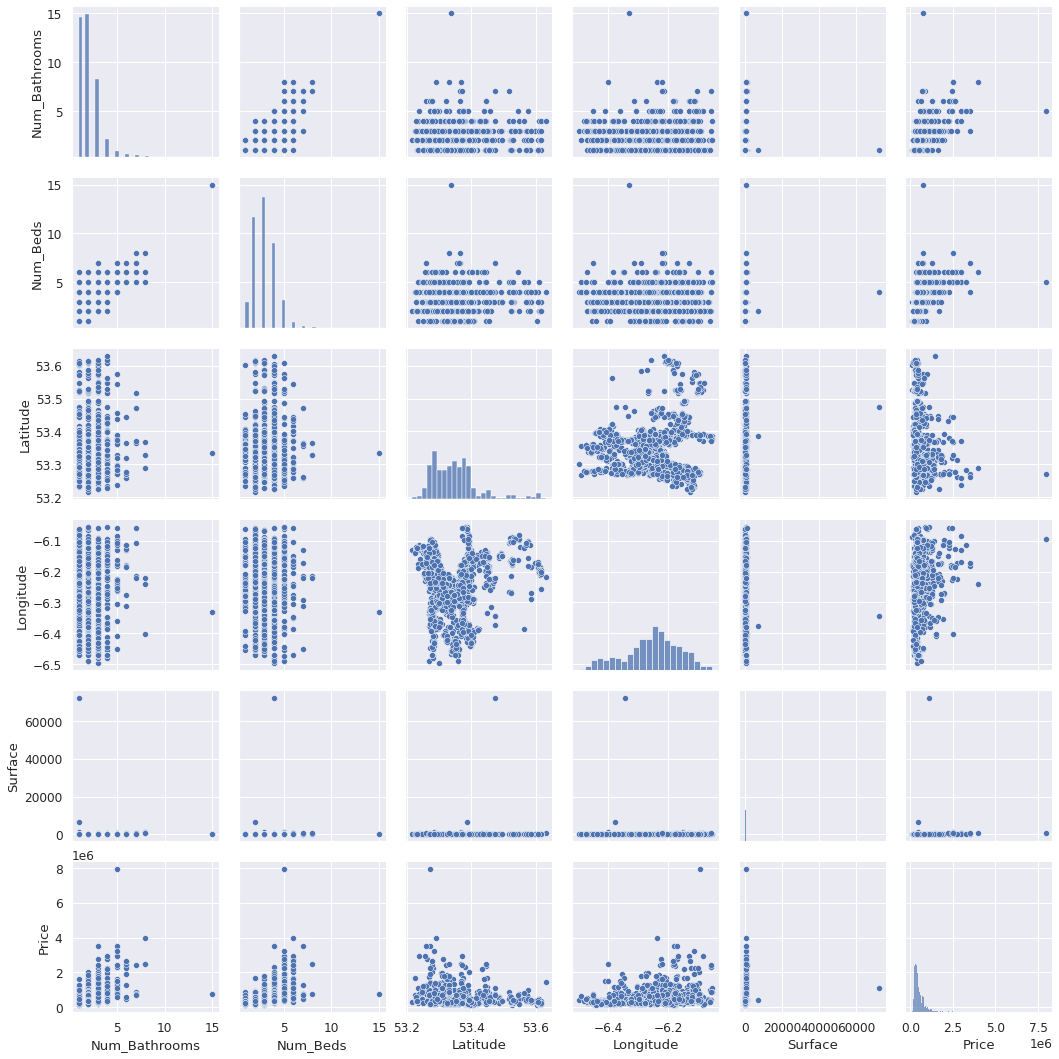

In [19]:
# Pairplot to see the relationship between numerical features. The method dropna() drops all rows with missing values 
# No of units and facility are removed due to high number of NULL values
print('Pairplots of numerical features')
sns.pairplot(data=df_train[['Num_Bathrooms','BER_class','Num_Beds','Latitude','Longitude','Surface','Price']].dropna())
plt.show()

In [20]:
# Get a read of Categorical Values
cat_cols = df_train.select_dtypes(include=['object'])     #strip out the categorical cols
cat_cols.columns[cat_cols.any()].tolist()           #convert col names to list
for i in cat_cols:                                  #loop through the cols
    print(cat_cols[i].value_counts(),"\n")          #print the summary to analyse

Castleknock    57
Malahide       50
Lucan          49
Rathfarnham    46
Clondalkin     41
               ..
Brittas         1
Smithfield      1
The Coombe      1
Ballymun        1
Oldbawn         1
Name: Location, Length: 142, dtype: int64 

D1                     182
D2                     173
C3                     154
C2                     144
C1                     133
E1                     110
G                      103
E2                     101
F                       89
B3                      78
B2                      48
A3                      37
SINo666of2006exempt     15
A2                      12
B1                       7
A1                       1
Name: BER_class, dtype: int64 

***PLEASE NOTE THIS PROPERTY WILL BE ON VIEW SATURDAY 7TH MARCH AT 10.45AM - 11.15AM. PLEASE MAIL/PHONE TO REGISTER YOUR ATTENDANCE***\r\nExceptional two-bedroom apartment situated on the first floor with a corner position offering exceptional views towards the river Dodder and Dublin Mountain

In [21]:
# Strip out the NLP Features
#df_train_nlp = df_train[nlp_features]

#Drop the NLP Features & Low Value Features
#df_train_eda = df_train.drop(drop_features, axis=1)

# Get a read of remaining Categorical Values
cat_cols = df_train.drop(drop_features, axis=1).select_dtypes(include=['object'])     #strip out the categorical cols
cat_cols.columns[cat_cols.any()].tolist()           #convert col names to list
for i in cat_cols:                                  #loop through the cols
    print(cat_cols[i].value_counts(),"\n")          #print the summary to analyse

***PLEASE NOTE THIS PROPERTY WILL BE ON VIEW SATURDAY 7TH MARCH AT 10.45AM - 11.15AM. PLEASE MAIL/PHONE TO REGISTER YOUR ATTENDANCE***\r\nExceptional two-bedroom apartment situated on the first floor with a corner position offering exceptional views towards the river Dodder and Dublin Mountains. Bright and spacious throughout, this apartment features a large south/east facing terrace, floor to ceiling glazing and stylish kitchen and bathrooms. Mount St. Anne's is an upmarket development adjacent to a host of amenities and a Luas Stop. The property is presented in turn-key condition and the accommodation comprises an entrance hall with large hot press, generous open plan living/dining room, kitchen with a separate utility room, two double bedrooms, master en-suite and a main bathroom. Must be viewed to be appreciated!\n\r\nLocation\r\nLocated in what has become one of Dublin's most sought after developments and with private access to the Milltown Luas Stop. Nearby Donnybrook, Milltown a

In [22]:
#Calculate missing values for the numerical features.
print(df_train.select_dtypes(exclude=['object']).isna().sum())

Index            0
ID               0
Num_Bathrooms    0
Num_Beds         0
Latitude         0
Longitude        0
Surface          0
Price            0
dtype: int64


# Detection / Removal of Outliers

In [23]:
df_train

,Index,ID,Location,Num_Bathrooms,Num_Beds,BER_class,Description,Services,Features,Latitude,Longitude,Type,Surface,Price
0,1,12409116,Ongar,2,2,C3,DNG are delighted to present to the market no....,NaN,None,53.396659,-6.438791,apartment,67.00,195000
1,2,12320330,North Strand,1,2,D1,13 Northbrook Terrace is a charming red brick ...,NaN,Bight and Spacious interior\nNumerous original...,53.357129,-6.239779,terraced,95.97,425000
2,3,12405953,Stepaside,3,3,A3,"Welcome to No. 6 Cotter Close, an immaculately...",NaN,Special Features\nLarge rear garden\nGenerous ...,53.266468,-6.222771,semi-detached,107.00,535000
3,4,12202582,Cabinteely,1,3,E1,Welcome to 3 Sycamore Walk!\n\r\nEnjoying a pr...,NaN,Wonderful 3 bed detached bungalow. \nAccom...,53.261600,-6.166738,detached,81.00,499000
4,5,12299336,Lusk,3,4,D1,'Four Seasons' comes to the market as a wonder...,NaN,Detached Property \nDouble Glazed Windows...,53.550731,-6.121415,detached,153.00,510000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1633,1634,12424903,Blackrock,1,2,C2,Built in c.1930 38 Stradbrook Road is a deligh...,"Parking,Gas Fired Central Heating,Alarm,Wheelc...",Extremely convenient location \nWheelchair acc...,53.292767,-6.166668,bungalow,64.00,500000
1634,1635,12383142,Blackrock,3,5,C1,An impressive three-story family home superbly...,NaN,Gas fired central heating with underfloor heat...,53.284975,-6.178685,detached,175.96,795000
1635,1636,12426975,Lucan,2,3,A3,DNG Lucan's leading estate agents are delighte...,NaN,None,53.351667,-6.435278,semi-detached,98.00,340000
1636,1637,12198921,Sandymount,8,8,D2,Holyrood Castle is a most distinctive 19th cen...,NaN,None,53.328997,-6.221030,detached,507.00,2500000


# Natural Language Processing

Natural language processing ([NLP](https://en.wikipedia.org/wiki/Natural_language_processing)) is a subfield of linguistics, computer science, and artificial intelligence.

* NLP concerned with the interactions between computers and human language.
* In particular how to program computers to process and analyze large amounts of natural language data. 
* The goal is a computer capable of "understanding" the contents of documents.
* Including the contextual nuances of the language within them. 
* The technology can then accurately extract information and insights contained in the documents.
* As well as categorize and organize the documents themselves. 

# Training & Test Data Split



In [24]:
df_subset_train_prepped = prepare_data(df_train,True)
df_subset_train_prepped[nlp_features].astype(str)

df_subset_train_nlp = nlp_data(df_subset_train_prepped[nlp_features].astype(object))
df_subset_train_vector, test1feature = vectorise_data(df_subset_train_nlp,'Features')

df_subset_train = pd.concat([df_subset_train_prepped, df_subset_train_vector], axis=1)

df_subset_train = df_subset_train.drop(nlp_features, axis=1)

df_subset_train

,Num_Bathrooms,Num_Beds,Latitude,Longitude,Type,Surface,Price,central_heating,double_glazed,fired_central,fired_central_heating,gas_fired,gas_fired_central,gas_fired_central_heating,glazed_windows,rear_garden,street_parking
0,2,2,53.396659,-6.438791,1,67.00,195000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1,2,53.357129,-6.239779,4,95.97,425000,0.345959,0.000000,0.381464,0.381464,0.387401,0.399521,0.399521,0.000000,0.346365,0.000000
2,3,3,53.266468,-6.222771,8,107.00,535000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.655053,0.755583
3,1,3,53.261600,-6.166738,9,81.00,499000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
4,3,4,53.550731,-6.121415,9,153.00,510000,0.000000,0.675182,0.000000,0.000000,0.000000,0.000000,0.000000,0.737651,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1601,1,1,53.325479,-6.277781,1,37.00,220000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1602,1,2,53.292767,-6.166668,5,64.00,500000,0.286656,0.304852,0.316076,0.316076,0.320995,0.331037,0.331037,0.333057,0.286993,0.331037
1603,3,5,53.284975,-6.178685,9,175.96,795000,0.299245,0.318239,0.329956,0.329956,0.335091,0.345574,0.345574,0.347683,0.000000,0.345574
1604,2,3,53.351667,-6.435278,8,98.00,340000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [25]:
# select some features columns just for the baseline model
# assume not all of the features are informative or useful
# in this exercise you could try all of them if possible

#featrain = ['Num_Bathrooms','Num_Beds','BER_class', 'Longitude', 'Latitude', 'Price', 'Features', 'Description']
#featrain = featrain + int2feature
#featrain = []
# dropna: remove missing values

# print(df_train_full.shape)

#if len(featrain) > 0:
  #df_subset_train = df_train_full[featrain].drop(nlp_features, axis=1)
#else:
  #df_subset_train = df_train_full.drop(nlp_features, axis=1)

df_subset_train = df_subset_train.dropna(axis=0)

df_cost = df_subset_train['Price']

df_subset_train = df_subset_train.drop(['Price'], axis=1)

#df_subset_train = pd.concat([df_subset_train,df_train_nlp])

print(df_subset_train.shape)
print(df_cost.shape)

(1606, 16)
(1606,)


In [26]:
# split data into training and test
from sklearn.model_selection import train_test_split

# training: 70% (0.7), test: 30% (0.3) 
# you could try any other combination 
# but consider 50% of training as the low boundary
X_train,X_test,y_train,y_test = train_test_split(df_subset_train, df_cost, test_size=0.3)

### Train dataset

In [27]:
# show first data frame rows 
X_train

,Num_Bathrooms,Num_Beds,Latitude,Longitude,Type,Surface,central_heating,double_glazed,fired_central,fired_central_heating,gas_fired,gas_fired_central,gas_fired_central_heating,glazed_windows,rear_garden,street_parking
808,2,3,53.466872,-6.236394,8,120.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0
1410,1,3,53.399392,-6.190572,4,68.45,0.318891,0.339133,0.351619,0.351619,0.357091,0.368262,0.368262,0.37051,0.000000,0.0
140,2,3,53.376545,-6.402168,2,98.88,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0
1459,3,4,53.319175,-6.252321,8,150.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0
1411,3,4,53.377814,-6.283439,8,141.00,0.000000,0.728113,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.685458,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,1,1,53.387446,-6.300091,1,59.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0
271,3,4,53.370837,-6.331256,6,112.70,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.0
1006,1,1,53.349259,-6.255467,1,45.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0
68,1,4,53.369369,-6.320865,4,121.20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0


### Test dataset

In [28]:
# show first data frame rows 
X_test

,Num_Bathrooms,Num_Beds,Latitude,Longitude,Type,Surface,central_heating,double_glazed,fired_central,fired_central_heating,gas_fired,gas_fired_central,gas_fired_central_heating,glazed_windows,rear_garden,street_parking
1188,2,2,53.273253,-6.257602,1,79.99,0.368787,0.000000,0.406635,0.406635,0.412964,0.425883,0.425883,0.000000,0.000000,0.000000
121,1,3,53.383873,-6.307115,4,81.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
688,3,3,53.525702,-6.178064,8,101.00,0.000000,0.484556,0.000000,0.000000,0.000000,0.000000,0.000000,0.529388,0.456169,0.526177
269,2,4,53.310699,-6.310096,5,178.00,0.339298,0.000000,0.374120,0.374120,0.379942,0.391829,0.391829,0.000000,0.000000,0.391829
240,2,4,53.368047,-6.198568,4,121.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487,1,4,53.358164,-6.245824,4,135.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
419,1,3,53.338801,-6.225516,4,79.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
960,2,4,53.368436,-6.266036,6,125.00,0.345959,0.000000,0.381464,0.381464,0.387401,0.399521,0.399521,0.000000,0.346365,0.000000
816,3,4,53.236733,-6.114934,9,190.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000


### Expected Cost dataset

In [29]:
# show first data frame rows 
y_train

808     390000
1410    190000
140     310000
1459    950000
1411    535000
         ...  
26      165000
271     520000
1006    235000
68      455000
557     425000
Name: Price, Length: 1124, dtype: int64

In [30]:
# train set, input columns
Xs_train = X_train.iloc[:,0:].values 

# train set, output column, cost
ys_train = y_train.values.reshape(-1, 1)

# test set, input columns
Xs_test = X_test.iloc[:,0:].values 

# test set, output column, cost
#y_test = y_test.values.reshape(-1, 1)

print(Xs_train.shape)
print(ys_train.shape)
print(Xs_test.shape)
print(y_test.shape)

(1124, 16)
(1124, 1)
(482, 16)
(482,)


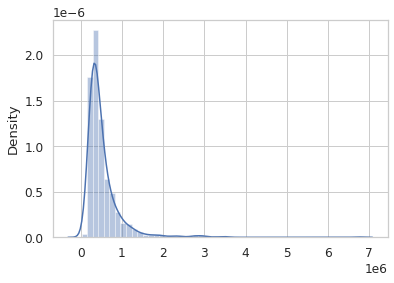

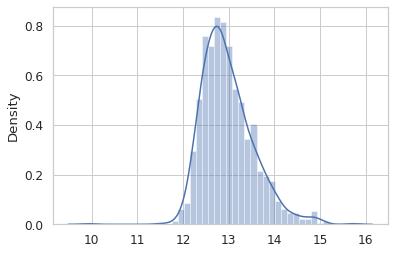

In [31]:
# StandardScaler() will normalize the features i.e. each column of X, 
# so, each column/feature/variable will have μ = 0 and σ = 1#

sc = StandardScaler()

Xss_train = np.hstack([Xs_train,Xs_train[:,[2]]**2])
xscaler = sc.fit(Xss_train)
Xn_train = xscaler.transform(Xss_train)

Xss_test = np.hstack([Xs_test,Xs_test[:,[2]]**2])
Xn_test = xscaler.transform(Xss_test)

#Quick Analysis of House Price Data
x = ys_train
sns.set_style('whitegrid')
sns.distplot(x)
plt.show()

x_log = np.log(x)
sns.distplot(x_log)
plt.show()

ylog = np.log(ys_train.astype('float'))
yscaler = StandardScaler().fit(ylog)
yn_train = yscaler.transform(ylog)

# PIECEWISE REGRESSION

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

In [32]:
# model
with pm.Model() as model:
    #prior over the parameters of linear regression
    alpha = pm.Normal('alpha', mu=0, sigma=30)
    #we have one beta for each column of Xn
    beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn_train.shape[1])
    #prior over the variance of the noise
    sigma = pm.HalfCauchy('sigma_n', 5)
    #linear regression model in matrix form
    mu = alpha + pm.math.dot(beta, Xn_train.T)
    #likelihood, be sure that observed is a 1d vector
    like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn_train[:,0])

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Finished [100%]: Average Loss = 1,067.5


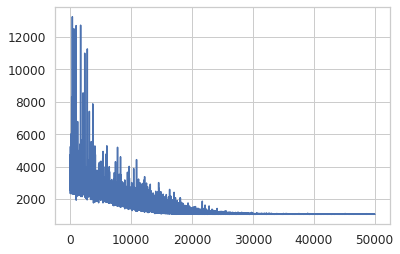

In [33]:
#number of iterations of the algorithms
iter = 50000 

# run the model
with model:
    approximation = pm.fit(iter, method='advi')
    
# check the convergence
plt.plot(approximation.hist);

In [34]:
# samples from the posterior
posterior = approximation.sample(5000)

In [35]:
# prediction
ll=np.mean(posterior['alpha']) + np.dot(np.mean(posterior['beta'],axis=0), Xn_test.T)
y_pred_BLR = np.exp(yscaler.inverse_transform(ll.reshape(-1,1)))[:,0]
print("MAE = ",(np.mean(abs(y_pred_BLR - y_test))))
print("MAPE = ",(np.mean(abs(y_pred_BLR - y_test) / y_test)))
print("RMSLE = ",(mean_squared_log_error(y_test,y_pred_BLR)))


MAE =  144852.20835827224
MAPE =  0.24497855798005008
RMSLE =  0.09835853474140296


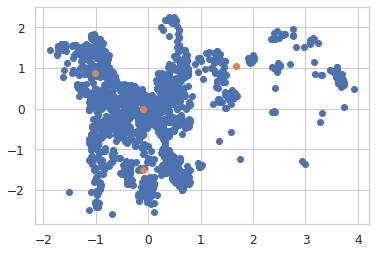

In [36]:
# training gaussian mixture model 
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4)
# clustering by features 1, 2
ind=[2,3]
X_ind = np.vstack([Xn_train[:,ind],Xn_test[:,ind]])
# Gaussian Mixture
gmm.fit(X_ind)
# plot blue dots
plt.scatter(X_ind[:,0],X_ind[:,1])
# centroids:  orange dots
plt.scatter(gmm.means_[:,0],gmm.means_[:,1])

In [37]:
# train clusters
clusters_train = gmm.predict(Xn_train[:,ind])
unique_train, counts_train = np.unique(clusters_train, return_counts=True)
dict(zip(unique_train, counts_train))

{0: 161, 1: 534, 2: 222, 3: 207}

In [38]:
# test clusters
clusters_test = gmm.predict(Xn_test[:,ind])
unique_test, counts_test = np.unique(clusters_test, return_counts=True)
dict(zip(unique_test, counts_test))

{0: 87, 1: 229, 2: 86, 3: 80}

In [39]:
# cluster 0
Xn0 = Xn_train[clusters_train==0,:]
Xtestn0 = Xn_test[clusters_test==0,:]
ylog0 = np.log(ys_train.astype('float')[clusters_train==0,:])
yscaler0 = StandardScaler().fit(ylog0)
yn0 = yscaler0.transform(ylog0)

In [40]:
# cluster 1
Xn1 = Xn_train[clusters_train==1,:]
Xtestn1 = Xn_test[clusters_test==1,:]
ylog1 = np.log(ys_train.astype('float')[clusters_train==1,:])
yscaler1 = StandardScaler().fit(ylog1)
yn1 = yscaler1.transform(ylog1)

In [41]:
# cluster 2
Xn2 = Xn_train[clusters_train==2,:]
Xtestn2 = Xn_test[clusters_test==2,:]
ylog2 = np.log(ys_train.astype('float')[clusters_train==2,:])
yscaler2 = StandardScaler().fit(ylog2)
yn2 = yscaler2.transform(ylog2)

In [42]:
# cluster 3
Xn3 = Xn_train[clusters_train==3,:]
Xtestn3 = Xn_test[clusters_test==3,:]
ylog3 = np.log(ys_train.astype('float')[clusters_train==3,:])
yscaler3 = StandardScaler().fit(ylog3)
yn3 = yscaler3.transform(ylog3)

In [43]:
# model_0
with pm.Model() as model_0:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn0
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn0.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn0.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn0[:,0])

with model_0:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior   
posterior0 = approximation.sample(5000)


Finished [100%]: Average Loss = 221.65


In [44]:
# model_1
with pm.Model() as model_1:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn1.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  #linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn1.T)
  # likelihood, # 
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn1[:,0])
  
with model_1:
  # iterations of the algorithm
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior1 = approximation.sample(5000)

Finished [100%]: Average Loss = 546.07


In [45]:
# model_2
with pm.Model() as model_2:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn2.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  # linear regression model in matrix form
  mu = alpha + pm.math.dot(beta, Xn2.T)
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn2[:,0])
    
with model_2:
  # iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior    
posterior2 = approximation.sample(5000)

Finished [100%]: Average Loss = 242.67


In [46]:
# model_3
with pm.Model() as model3:
  # prior over the parameters of linear regression
  alpha = pm.Normal('alpha', mu=0, sigma=30)
  # we have a beta for each column of Xn
  beta = pm.Normal('beta', mu=0, sigma=30, shape=Xn3.shape[1])
  # prior over the variance of the noise
  sigma = pm.HalfCauchy('sigma_n', 5)
  # linear regression relationship
  mu = alpha + pm.math.dot(beta, Xn3.T)#linear regression model in matrix form
  # likelihood, be sure that observed is a 1d vector
  like = pm.Normal('like', mu=mu, sigma=sigma, observed=yn3[:,0])
    
with model3:
  # number of iterations of the algorithms
  approximation = pm.fit(40000,method='advi')

# samples from the posterior     
posterior3 = approximation.sample(5000)

Finished [100%]: Average Loss = 270.37


In [47]:
# Posterior predictive checks (PPCs)
def ppc(alpha,beta,sigma, X,  nsamples=500):
    #we select nsamples random samples from the posterior
    ind = np.random.randint(0,beta.shape[0],size=nsamples)
    alphai = alpha[ind]
    betai = beta[ind,:]
    sigmai = sigma[ind]

    Ypred = np.zeros((nsamples,X.shape[0]))
    for i in range(X.shape[0]):
        #we generate data from linear model
        y_pred = alphai + np.dot(betai, X[i:i+1,:].T).T +np.random.randn(len(sigmai))*sigmai
        Ypred[:,i]=y_pred[0,:]
    return Ypred

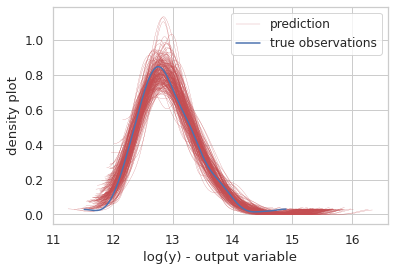

In [48]:
#Simulation
Ypred0 = yscaler0.inverse_transform(ppc(posterior0['alpha'],posterior0['beta'],posterior0['sigma_n'],Xn0,  nsamples=200))
for i in range(Ypred0.shape[0]):
    az.plot_dist( Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred0[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog0,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

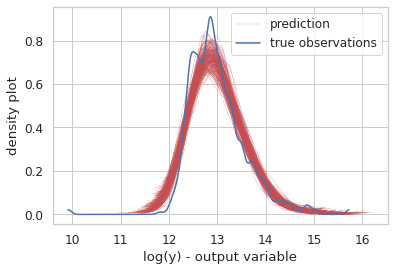

In [49]:
#Simulation
Ypred1 = yscaler1.inverse_transform(ppc(posterior1['alpha'],posterior1['beta'],posterior1['sigma_n'],Xn1,  nsamples=200))
for i in range(Ypred1.shape[0]):
    az.plot_dist( Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred1[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog1,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

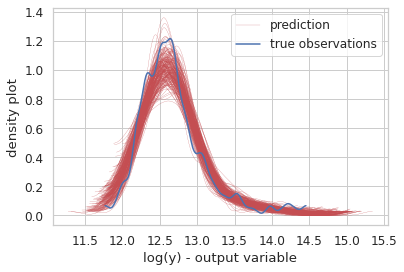

In [50]:
#Simulation
Ypred2 = yscaler2.inverse_transform(ppc(posterior2['alpha'],posterior2['beta'],posterior2['sigma_n'],Xn2,  nsamples=200))
for i in range(Ypred2.shape[0]):
    az.plot_dist( Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred2[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog2,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

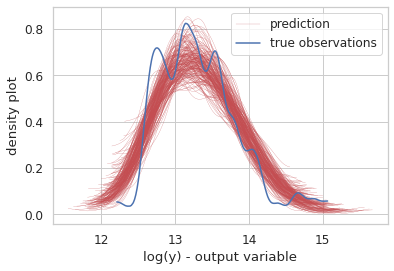

In [51]:
#Simulation
Ypred3 = yscaler3.inverse_transform(ppc(posterior3['alpha'],posterior3['beta'],posterior3['sigma_n'],Xn3,nsamples=200))
for i in range(Ypred3.shape[0]):
    az.plot_dist( Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2})
az.plot_dist(Ypred3[i,:],color='r',plot_kwargs={"linewidth": 0.2}, label="prediction")
#plt.plot(np.linspace(-8,8,100),norm.pdf(np.linspace(-8,8,100),df=np.mean(posterior_1['nu'])))
#plt.xlim([0,10e7])
az.plot_dist(ylog3,label='true observations');
plt.legend()
plt.xlabel("log(y) - output variable")
plt.ylabel("density plot");

In [52]:
# cluster 0
y_pred_BLR0 = np.exp(yscaler0.inverse_transform(np.mean(posterior0['alpha']) 
              + np.dot(np.mean(posterior0['beta'],axis=0), Xtestn0.T)))
print("Size Cluster0", np.sum(clusters_test==0), ", MAE Cluster0=",
      (np.mean(abs(y_pred_BLR0 - y_test[clusters_test==0]))))

# cluster 1
y_pred_BLR1 = np.exp(yscaler1.inverse_transform(np.mean(posterior1['alpha']) 
              + np.dot(np.mean(posterior1['beta'],axis=0), Xtestn1.T)))
print("Size Cluster1", np.sum(clusters_test==1), ", MAE Cluster1=",
      (np.mean(abs(y_pred_BLR1 - y_test[clusters_test==1]))))

# cluster 2
y_pred_BLR2 = np.exp(yscaler2.inverse_transform(np.mean(posterior2['alpha']) 
              + np.dot(np.mean(posterior2['beta'],axis=0), Xtestn2.T)))
print("Size Cluster2", np.sum(clusters_test==2), ", MAE Cluster2=",
      (np.mean(abs(y_pred_BLR2 - y_test[clusters_test==2]))))

# cluster 3
y_pred_BLR3 = np.exp(yscaler3.inverse_transform(np.mean(posterior3['alpha']) 
              + np.dot(np.mean(posterior3['beta'],axis=0), Xtestn3.T)))
print("Size Cluster3", np.sum(clusters_test==3), ", MAE Cluster3=",
      (np.mean(abs(y_pred_BLR3 - y_test[clusters_test==3]))))

# joint
joint=np.hstack([abs(y_pred_BLR0 - y_test[clusters_test==0]),
                 abs(y_pred_BLR1 - y_test[clusters_test==1]),
                 abs(y_pred_BLR2 - y_test[clusters_test==2]),
                 abs(y_pred_BLR3 - y_test[clusters_test==3])])

# joint MAPE
joint_MAPE=np.hstack([abs(y_pred_BLR0 - y_test[clusters_test==0]) / y_test[clusters_test==0],
                     abs(y_pred_BLR1 - y_test[clusters_test==1]) / y_test[clusters_test==1],
                     abs(y_pred_BLR2 - y_test[clusters_test==2]) / y_test[clusters_test==2],
                     abs(y_pred_BLR3 - y_test[clusters_test==3]) / y_test[clusters_test==3]
                    ])

# joint RMSLE
joint_rmsle=np.hstack([mean_squared_log_error(y_test[clusters_test==0],y_pred_BLR0),
                 mean_squared_log_error(y_test[clusters_test==1],y_pred_BLR1),
                 mean_squared_log_error(y_test[clusters_test==2],y_pred_BLR2),
                 mean_squared_log_error(y_test[clusters_test==3],y_pred_BLR3)])

# MAE
print("MAE=",np.mean(joint))

# MAPE
print("MAPE=",np.mean(joint_MAPE))

# RMSLE
print("RMSLE=",np.mean(joint_rmsle))

Size Cluster0 87 , MAE Cluster0= 162635.97081993148
Size Cluster1 229 , MAE Cluster1= 116423.5408004783
Size Cluster2 86 , MAE Cluster2= 58552.27238758751
Size Cluster3 80 , MAE Cluster3= 260057.864315213
MAE= 138278.9312763343
MAPE= 0.2169842355672448
RMSLE= 0.08230852418331339


# BAYESIAN NN

A [Bayesian network](https://en.wikipedia.org/wiki/Bayesian_network) (also known as a Bayes network, Bayes net, belief network, or decision network) is a probabilistic graphical model that represents a set of variables and their conditional dependencies via a directed acyclic graph (DAG). 

* Bayesian networks are ideal for taking an event that occurred and predicting the likelihood that any one of several possible known causes was the contributing factor. 
* For example, a Bayesian network could represent the probabilistic relationships between diseases and symptoms. 
* Given symptoms, the network can be used to compute the probabilities of the presence of various diseases.

Your comments, explanation, and references here.

In [53]:
# your code here

# https://theano-pymc.readthedocs.io/en/latest/
import theano

# add a column of ones to include an intercept in the model
x1 = np.hstack([np.ones((Xn_train.shape[0],1)), Xn_train])
floatX = theano.config.floatX

l = 15
# Initialize random weights between each layer
# we do that to help the numerical algorithm that computes the posterior
init_1 = np.random.randn(x1.shape[1], l).astype(floatX)
init_out = np.random.randn(l).astype(floatX)

# pymc3 model as neural_network
with pm.Model() as neural_network:
    # we convert the data in theano type so we can do dot products with the correct type.
    ann_input = pm.Data('ann_input', x1)
    ann_output = pm.Data('ann_output', yn_train)
    # Priors 
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_1', 0, sigma=1,
                             shape=(x1.shape[1], l), testval=init_1)
    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_0', 0, sigma=1,
                              shape=(l,),testval=init_out)

    # Build neural-network using tanh activation function
    # Inner layer
    act_1 = pm.math.tanh(pm.math.dot(ann_input,weights_in_1))
    # Linear layer, like in Linear regression
    act_out = pm.Deterministic('act_out',pm.math.dot(act_1, weights_2_out))

    # standard deviation of noise
    sigma = pm.HalfCauchy('sigma',5)

    # Normal likelihood
    out = pm.Normal('out',
                       act_out,
                       sigma=sigma,
                       observed=ann_output[:,0])

In [54]:
# some parameters
par1 = 30  # start with 100, then use 1000+
par2 = 300 # start with 1000, then use 10000+

# neural network
with neural_network:
    posterior = pm.sample(par1,tune=par2,chains=1)

Only 30 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, w_0, w_1]


Sampling 1 chain for 300 tune and 30 draw iterations (300 + 30 draws total) took 127 seconds.


In [55]:
# we can do instead an approximated inference
param3 = 40000 # start with 1000, then use 50000+
VI = 'advi'  # 'advi', 'fullrank_advi', 'svgd', 'asvgd', 'nfvi'
OP = pm.adam # pm.adam, pm.sgd, pm.adagrad, pm.adagrad_window, pm.adadelta
LR = 0.0008    

with neural_network:
    approx = pm.fit(param3, method=VI, obj_optimizer=pm.adam(learning_rate=LR))

Finished [100%]: Average Loss = 902.16


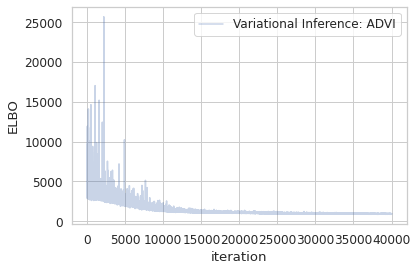

In [56]:
# plot 
pb.plot(approx.hist, label='Variational Inference: '+ VI.upper(), alpha=.3)
pb.legend(loc='upper right')
pb.ylabel('ELBO')
pb.xlabel('iteration');

In [57]:
# draw samples from variational posterior
D = 500
posterior = approx.sample(draws=D)

In [58]:
# add a column of ones to include an intercept in the model
x2 = np.hstack([np.ones((Xn_test.shape[0],1)), Xn_test])
y_final_pred = []
for i in range(posterior['w_1'].shape[0]):
    #inner layer
    t1 = np.tanh(np.dot(posterior['w_1'][i,:,:].T,x2.T))
    #outer layer
    y_final_pred.append(np.dot(posterior['w_0'][i,:],t1))

# predictions   
y_final_pred = np.array(y_final_pred).mean(axis=0)

In [59]:
#We need to do the inverse transformation and scaling that was carried out on the y values at the start
y_val_pred_final = np.exp(yscaler.inverse_transform(y_final_pred))

print("MAE = ",(np.mean(abs(y_val_pred_final - y_test))))
print("MAPE = ",(np.mean(abs(y_val_pred_final - y_test) / y_test)))
print("RMSLE = ",(mean_squared_log_error(y_test,y_val_pred_final)))

MAE =  124753.69602876577
MAPE =  0.19915663295823813
RMSLE =  0.07054605633411773


# TEST DATA SET

In [60]:
df_test_prepped = prepare_data(df_test, False)
df_test_prepped[nlp_features].astype(str)
df_test_nlp = nlp_data(df_test_prepped[nlp_features].astype(object))
df_test_vector, test2feature = vectorise_data(df_test_nlp,'Features')

df_test_full = pd.concat([df_test_prepped, df_test_vector], axis=1)

df_test_full = df_test_full.drop(nlp_features, axis=1)

cols1 = df_test_full.columns
cols2 = X_test.columns

diff_cols = cols2.difference(cols1)

matching = [s for s in diff_cols if "Location_" in s]

print(X_test.shape, df_test_full.shape)

for i in range(X_test.shape[1] - df_test_full.shape[1]):
   df_test_full["Dummy"+str(i)] = 0

print(X_test.shape, df_test_full.shape)

(482, 16) (702, 16)
(482, 16) (702, 16)


In [61]:
Xt_test = df_test_full.iloc[:,0:].values 
Xtt_test = np.hstack([Xt_test,Xt_test[:,[2]]**2])
xtscaler = sc.fit(Xtt_test)
Xtn_test = xtscaler.transform(Xtt_test)

In [62]:
# add a column of ones to include an intercept in the model
x2 = np.hstack([np.ones((Xtn_test.shape[0],1)), Xtn_test])
y_pred = []
for i in range(posterior['w_1'].shape[0]):
    #inner layer
    t1 = np.tanh(np.dot(posterior['w_1'][i,:,:].T,x2.T))
    #outer layer
    y_pred.append(np.dot(posterior['w_0'][i,:],t1))

# predictions   
y_pred = np.array(y_pred).mean(axis=0)

y_pred_final = np.round(np.exp(yscaler.inverse_transform(y_pred)),2)

In [63]:
g6_kaggle_price = pd.DataFrame(y_pred_final, columns=['Price'])
test_predictions = pd.concat([df_test['Index'], g6_kaggle_price.astype(int)], axis=1)
test_predictions.to_csv(Path + 'ET5003_BayesianNN_Kaggle_Team6.csv', index=False)

# REFERENCES

Thatdatatho.com. 2021. Predicting Housing Prices with Natural Language Processing NLP and Tidymodels. [online] Available at: <https://thatdatatho.com/predicting-housing-prices-nlp/> [Accessed 8 October 2021]

Medium. 2021. House Prices Prediction Using Deep Learning. [online] Available at: <https://towardsdatascience.com/house-prices-prediction-using-deep-learning-dea265cc3154> [Accessed 8 October 2021]

Arno.uvt.nl. Predicting Real Estate Price Using Text Mining 2021. [online] Available at: <http://arno.uvt.nl/show.cgi?fid=134740> [Accessed 11 October 2021].




# SUMMARY

Your summary here.